In [1]:
import os,time

from os import listdir
from os.path import isfile, join, exists

import torch
import torchaudio,torchvision
from torch import optim
import torch.nn.functional as F
from torchvision import transforms,datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import pandas as pd
import torch.nn as nn
import numpy as np
from sklearn import metrics
from utils import *
from NN import *
import random
import torchviz
from imblearn.under_sampling import RandomUnderSampler

In [2]:
device

'cpu'

In [3]:
torch.manual_seed(42)
undersample = False

In [4]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [5]:
bird_data = pd.read_csv("./warblrb10k_public_metadata.csv")

In [6]:
class AudioDataset(Dataset):
    
    def __init__(self, data, dir_path, sampling_rate=44100, undersample=False) -> None:
        super().__init__()
        self.dir_path = dir_path
        self.rus = None
        if undersample:
            self.rus = RandomUnderSampler(random_state=42)
            self.id_train, self.y_train = self.rus.fit_resample(np.array(data["itemid"]).reshape(-1, 1), data["hasbird"].astype("float32"))
            
            self.id_train = pd.Series(self.id_train.reshape(-1))
            self.y_train = pd.Series(self.y_train)
            
            print("Data has been resampled, New labels : ", self.y_train.value_counts())
            
        else:
            self.id_train = data["itemid"]
            self.y_train = data["hasbird"].astype("float32")
            
        self.sampling_rate = sampling_rate
        self.sample_rate = sampling_rate
        
    def __len__(self):
        return self.y_train.size
    
    def __getitem__(self, index):
        audio,sample_rate = torchaudio.load(self.dir_path + self.id_train[index] + ".wav")
        
        if sample_rate != self.sampling_rate:
            audio = torchaudio.functional.resample(audio, orig_freq=sample_rate, new_freq=self.sampling_rate)

        return F.pad(audio.view(-1), [0,self.sampling_rate-audio.numel()], "constant", 0), self.y_train[index]
    
    def getaudio(self, index):
        audio,sample_rate = torchaudio.load(self.dir_path + self.id_train[index] + ".wav")
        
        if sample_rate != self.sampling_rate:
            audio = torchaudio.functional.resample(audio, orig_freq=sample_rate, new_freq=self.sampling_rate)
            
        return audio
    
    def get_stats(self):
        
        print(self.y_train.value_counts())
    
    def display(self):
        index = random.randint(0, len(self.id_train))
        waveform, sample_rate = torchaudio.load(self.dir_path + self.id_train[index] + ".wav")
        plot_waveform(waveform, self.sample_rate)
        plot_specgram(waveform, self.sample_rate)
        print("Bird : ", self.y_train[index])

In [7]:
class ImageDataset(Dataset):
    
    def __init__(self, data, dir_path) -> None:
        super().__init__()
        self.dir_path = dir_path
        
        self.rus = None
        if undersample:
            self.rus = RandomUnderSampler(random_state=42)
            self.id_train, self.y_train = self.rus.fit_resample(np.array(data["itemid"]).reshape(-1, 1), data["hasbird"].astype("float32"))
            
            self.id_train = pd.Series(self.id_train.reshape(-1))
            self.y_train = pd.Series(self.y_train)
            
            print("Data has been resampled, New labels : ", self.y_train.value_counts())
            
        else:
            self.id_train = data["itemid"]
            self.y_train = data["hasbird"].astype("float32")
        
    def __len__(self):
        return self.y_train.size
    
    def __getitem__(self, index):
        image = ToTensor()(Image.open(self.dir_path + self.id_train[index] + ".png"))

        return image[:3, :, :], self.y_train[index]
    
    def display(self):
        index = random.randint(0, len(self.id_train))
        image = ToTensor()(Image.open(self.dir_path + self.id_train[index] + ".png"))
        print(image.shape)
        ToPILImage()(image).show()
        print("Bird : ", self.y_train[index])
        

In [8]:
def test(model, dataset):
    pass

In [9]:
#sampling_rate = 16000 # 77 cnn - 76 mlp
sampling_rate = 8000 # 79.1 cnn - 75.9 mlp - 76.6 lstm - 84.3 spectrogram cnn
#sampling_rate = 44100 # 77 cnn - 69.9 mlp

In [10]:
audio_dataset = AudioDataset(bird_data, dir_path="./wav/", sampling_rate=sampling_rate, undersample=undersample)
train_set, val_set = torch.utils.data.random_split(audio_dataset, [int(0.8*len(audio_dataset)), int(0.2*len(audio_dataset))])

In [11]:
bird_test_data = pd.read_csv("./test2/ff1010bird_metadata.csv")
audio_test_dataset = AudioDataset(bird_test_data, dir_path="./test2/wav/", sampling_rate=sampling_rate)

In [12]:
audio_test_dataset.get_stats()

0.0    5755
1.0    1935
Name: hasbird, dtype: int64


In [13]:
5755 / (5755 + 1935)

0.7483745123537061

In [14]:
generate_all_spectrograms(audio_dataset, sampling_rate)

In [15]:
generate_all_waveforms(audio_dataset, sampling_rate)

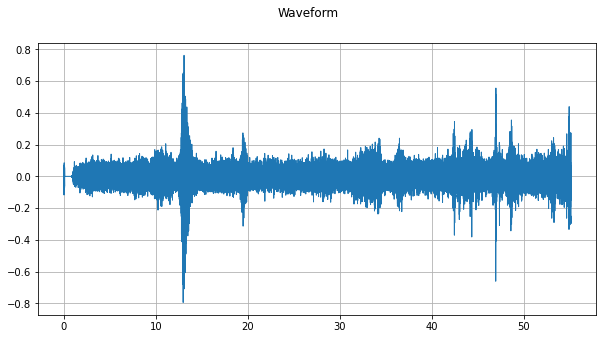

Spectrogram Shape, channels, frames :  (1, 441344) 1 441344
[[1.48857723e-07 8.06565819e-08 3.21095758e-08 ... 1.30405370e-04
  8.21123831e-06 2.25758970e-04]
 [2.36378412e-06 6.07592127e-07 3.62638297e-06 ... 1.81629767e-04
  1.20151305e-04 4.35833571e-04]
 [3.52841961e-06 1.11352315e-06 9.46587938e-06 ... 2.70811904e-05
  3.84516748e-06 1.01589764e-04]
 ...
 [6.49256962e-11 2.50399051e-14 5.02636342e-12 ... 8.44141851e-12
  2.29779921e-11 1.02819227e-11]
 [6.61406580e-11 2.90316243e-11 4.17080762e-13 ... 1.28104979e-11
  1.68018616e-11 3.30488910e-12]
 [1.76054363e-11 3.44253614e-11 5.93647563e-13 ... 8.09955985e-12
  8.94879166e-12 2.11183574e-13]]


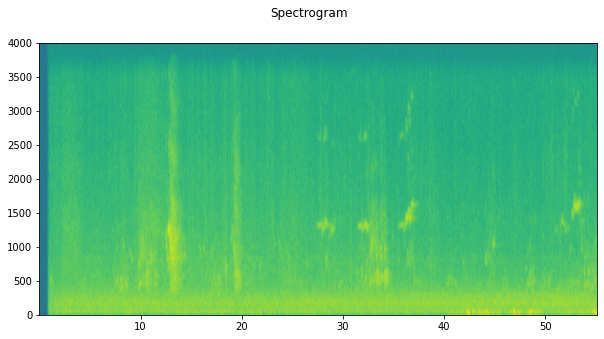

Bird :  1.0


In [15]:
audio_dataset.display()

In [16]:
audio_dataset.get_stats()

0.0    1955
1.0    1955
Name: hasbird, dtype: int64


In [17]:
train_set[0]

(tensor([-4.7475e-06, -2.3319e-06, -1.4075e-05,  ...,  6.6924e-04,
         -4.0542e-04, -2.0209e-03]),
 0.0)

In [18]:
spectrogram_dataset = ImageDataset(bird_data, "./spectrogram/")
spec_train_set, spec_val_set = torch.utils.data.random_split(spectrogram_dataset, [int(0.8*len(spectrogram_dataset)), int(0.2*len(spectrogram_dataset))])

Data has been resampled, New labels :  0.0    1955
1.0    1955
Name: hasbird, dtype: int64


In [19]:
spectrogram_dataset.display()

torch.Size([4, 288, 432])
Bird :  1.0


In [ ]:
waveform_dataset = ImageDataset(bird_data, "./spectrogram/")
wave_train_set, wave_val_set = torch.utils.data.random_split(waveform_dataset, [int(0.8*len(waveform_dataset)), int(0.2*len(waveform_dataset))])

In [ ]:
waveform_dataset.display()

## Training Sets

In [20]:
counts = train_set.dataset.y_train.loc[train_set.indices].value_counts()
counts

0.0    1593
1.0    1535
Name: hasbird, dtype: int64

In [21]:
counts[1] / counts.sum()

0.4907289002557545

In [22]:
counts = spec_train_set.dataset.y_train.loc[spec_train_set.indices].value_counts()
counts

1.0    1579
0.0    1549
Name: hasbird, dtype: int64

In [23]:
counts[1] / counts.sum()

0.5047953964194374

## Validation Sets

In [24]:
counts = val_set.dataset.y_train.loc[val_set.indices].value_counts()
counts

1.0    420
0.0    362
Name: hasbird, dtype: int64

In [25]:
counts[1] / counts.sum()

0.5370843989769821

In [26]:
counts = spec_val_set.dataset.y_train.loc[spec_val_set.indices].value_counts()
counts

0.0    406
1.0    376
Name: hasbird, dtype: int64

In [27]:
counts[1] / counts.sum()

0.48081841432225064

## CNN

### Amplitude Based CNN

In [32]:
cnn_model = CNNModel(1).to(device)

In [33]:
cnn_model

CNNModel(
  (conv_block1): ConvBlock1d(
    (conv1): Conv1d(1, 10, kernel_size=(5,), stride=(1,))
    (max_pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): ConvBlock1d(
    (conv1): Conv1d(10, 20, kernel_size=(5,), stride=(1,))
    (max_pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): ConvBlock1d(
    (conv1): Conv1d(20, 30, kernel_size=(5,), stride=(1,))
    (max_pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): ConvBlock1d(
    (conv1): Conv1d(30, 60, kernel_size=(5,), stride=(1,))
    (max_pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=660, out_features=1250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1250, out_features=625, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inpl

In [34]:
#torchviz.make_dot(cnn_model(torch.rand((1, sampling_rate)).to(device)))

In [35]:
train(cnn_model, train_set, val_set, 30, 0.001, 0)

Epoch: 1/30 -- [1400/3128 (100.0%)]	Loss: 0.6941876220703125	Accuracy: 0.486	Time taken: 85.5625	Validation Loss: 0.6995503306388855 || Validation Accuracy: 0.463
Epoch: 2/30 -- [1400/3128 (100.0%)]	Loss: 0.6934083127975463	Accuracy: 0.509	Time taken: 82.546875	Validation Loss: 0.6951966285705566 || Validation Accuracy: 0.463
Epoch: 3/30 -- [1400/3128 (100.0%)]	Loss: 0.6931692337989808	Accuracy: 0.516	Time taken: 83.46875	Validation Loss: 0.6930838823318481 || Validation Accuracy: 0.460
Epoch: 4/30 -- [1400/3128 (100.0%)]	Loss: 0.6898245120048523	Accuracy: 0.517	Time taken: 83.96875	Validation Loss: 0.6988876461982727 || Validation Accuracy: 0.455
Epoch: 5/30 -- [1400/3128 (100.0%)]	Loss: 0.6832186651229858	Accuracy: 0.531	Time taken: 82.78125	Validation Loss: 0.8587779998779297 || Validation Accuracy: 0.481
Epoch: 6/30 -- [1400/3128 (100.0%)]	Loss: 0.6890418577194214	Accuracy: 0.511	Time taken: 84.515625	Validation Loss: 0.8937179446220398 || Validation Accuracy: 0.463
Epoch: 7/30 -- 

### Spectrogram Based CNN

In [28]:
spec_cnn_model = SpecCNNModel(3).to(device)

In [29]:
spec_cnn_model

SpecCNNModel(
  (conv_block1): ConvBlock2d(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): ConvBlock2d(
    (conv1): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): ConvBlock2d(
    (conv1): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): ConvBlock2d(
    (conv1): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=480, out_features=1250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1250, out_features=6

In [30]:
train(spec_cnn_model, spec_train_set, spec_val_set, 30, 0.001, 0)

Epoch: 1/30 -- [1400/3128 (100.0%)]	Loss: 0.6792557740211487	Accuracy: 0.585	Time taken: 295.640625	Validation Loss: 0.6681586503982544 || Validation Accuracy: 0.609
Epoch: 2/30 -- [1400/3128 (100.0%)]	Loss: 0.6443655180931092	Accuracy: 0.647	Time taken: 79.90625	Validation Loss: 0.7278816103935242 || Validation Accuracy: 0.492
Epoch: 3/30 -- [1400/3128 (100.0%)]	Loss: 0.595639419555664	Accuracy: 0.684	Time taken: 79.96875	Validation Loss: 0.6668562293052673 || Validation Accuracy: 0.614
Epoch: 4/30 -- [1400/3128 (100.0%)]	Loss: 0.5494222128391266	Accuracy: 0.714	Time taken: 79.921875	Validation Loss: 0.5375648736953735 || Validation Accuracy: 0.742
Epoch: 5/30 -- [1400/3128 (100.0%)]	Loss: 0.514701247215271	Accuracy: 0.731	Time taken: 79.359375	Validation Loss: 0.5608158111572266 || Validation Accuracy: 0.692
Epoch: 6/30 -- [1400/3128 (100.0%)]	Loss: 0.4964510786533356	Accuracy: 0.747	Time taken: 79.671875	Validation Loss: 0.5105489492416382 || Validation Accuracy: 0.729
Epoch: 7/30 -

### Waveform Based CNN

In [ ]:
wave_cnn_model = SpecCNNModel(3).to(device)

In [ ]:
wave_cnn_model

In [ ]:
train(wave_cnn_model, wave_train_set, wave_val_set, 30, 0.001, 0)

## LSTM

In [28]:
input_length = sampling_rate
input_size = 1
batch_size = 128
num_layers = 3
#hidden_size = int(sampling_rate / 20)
hidden_size = 10
lstm_model = LSTMModel(input_size, hidden_size, num_layers).to(device)

In [29]:
lstm_model

LSTMModel(
  (lstm): LSTM(1, 10, num_layers=3, batch_first=True)
  (classifier): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
train_lstm(lstm_model, train_set, val_set, 30, 0.001, batch_size=batch_size, num_layers=num_layers, hidden_size=hidden_size, augmentation_prob=0)

Epoch: 1/30 -- [1400/3128 (100.0%)]	Loss: 0.6942688369750977	Accuracy: 0.491	Time taken: 686.453125	Validation Loss: 0.691883385181427 || Validation Accuracy: 0.537
Epoch: 2/30 -- [1400/3128 (100.0%)]	Loss: 0.6933090996742248	Accuracy: 0.491	Time taken: 658.296875	Validation Loss: 0.6930728554725647 || Validation Accuracy: 0.535
Epoch: 3/30 -- [1400/3128 (100.0%)]	Loss: 0.6930251550674439	Accuracy: 0.510	Time taken: 686.890625	Validation Loss: 0.6939836740493774 || Validation Accuracy: 0.463
Epoch: 4/30 -- [1400/3128 (100.0%)]	Loss: 0.6931650304794311	Accuracy: 0.509	Time taken: 683.671875	Validation Loss: 0.6959977149963379 || Validation Accuracy: 0.463
Epoch: 5/30 -- [1400/3128 (100.0%)]	Loss: 0.6930918192863464	Accuracy: 0.509	Time taken: 692.625	Validation Loss: 0.6937938928604126 || Validation Accuracy: 0.463
Epoch: 6/30 -- [1400/3128 (100.0%)]	Loss: 0.6929250884056092	Accuracy: 0.509	Time taken: 692.0	Validation Loss: 0.6950171589851379 || Validation Accuracy: 0.463
Epoch: 7/30 -

KeyboardInterrupt: 

In [44]:
torch.save(lstm_model.state_dict(), "lstm_model.pt")

## MLP

In [31]:
mlp_model = MLPModel(sampling_rate).to(device)

In [32]:
mlp_model

MLPModel(
  (fc1): Linear(in_features=8000, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=250, bias=True)
  (fc5): Linear(in_features=250, out_features=1, bias=True)
)

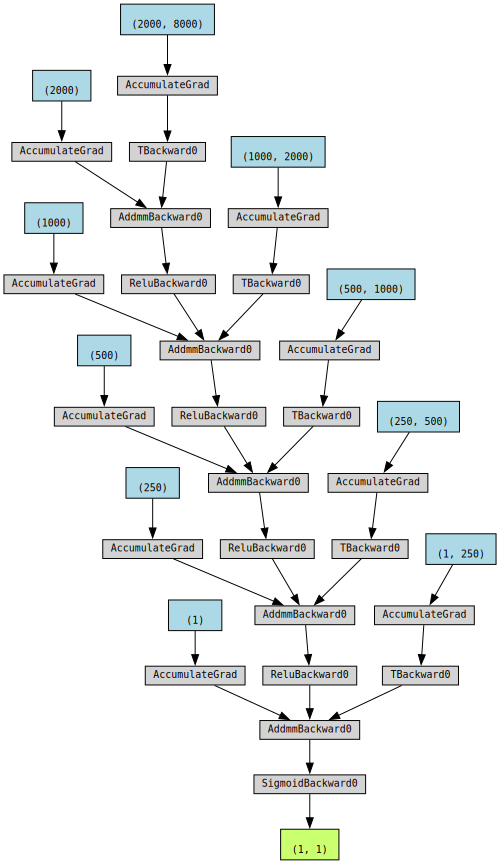

In [33]:
torchviz.make_dot(mlp_model(torch.rand((1, sampling_rate)).to(device)))

In [34]:
train(mlp_model, train_set, val_set, 30, 0.001, 0)

Epoch: 1/30 -- [1400/3128 (100.0%)]	Loss: 0.6939388489723206	Accuracy: 0.502	Time taken: 103.0625	Validation Loss: 0.6943197250366211 || Validation Accuracy: 0.463
Epoch: 2/30 -- [1400/3128 (100.0%)]	Loss: 0.6642134308815002	Accuracy: 0.584	Time taken: 100.015625	Validation Loss: 0.7137430310249329 || Validation Accuracy: 0.490
Epoch: 3/30 -- [1400/3128 (100.0%)]	Loss: 0.6242299890518188	Accuracy: 0.623	Time taken: 104.671875	Validation Loss: 0.7096439599990845 || Validation Accuracy: 0.488
Epoch: 4/30 -- [1400/3128 (100.0%)]	Loss: 0.600900387763977	Accuracy: 0.643	Time taken: 100.140625	Validation Loss: 0.7199287414550781 || Validation Accuracy: 0.487
Epoch: 5/30 -- [1400/3128 (100.0%)]	Loss: 0.5767802906036377	Accuracy: 0.674	Time taken: 101.5625	Validation Loss: 0.7185817360877991 || Validation Accuracy: 0.477
Epoch: 6/30 -- [1400/3128 (100.0%)]	Loss: 0.5624547266960144	Accuracy: 0.679	Time taken: 99.34375	Validation Loss: 0.738405704498291 || Validation Accuracy: 0.482
Epoch: 7/30 